In [39]:
# work in progress
import tensorflow
tensorflow.test.gpu_device_name()

2023-01-11 15:30:09.302928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:30:09.303486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:30:09.303848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:30:09.304229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:30:09.304561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

'/device:GPU:0'

5403 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


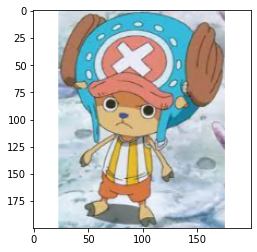

In [40]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('../input/onepiecedata200/out2/train/Chopper/1.jpg', 'r')


imshow(np.asarray(pil_im))

In [41]:

from tensorflow.keras import backend as K
from time import time

# DATA SOURCE --------------------------------------------------

train_data_dir = '../input/onepiecedata200/out2/train'
validation_data_dir = '../input/onepiecedata200/out2/val'
test_data_dir = '../input/onepiecedata200/out2/test'
image_size = (200, 200)
batch_size = 32

In [42]:
train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    #validation_split=0.2,
    #subset="training",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
validation_ds = validation_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Found 3559 files belonging to 10 classes.
Found 442 files belonging to 10 classes.
Found 452 files belonging to 10 classes.


# **Image Augmentation**

In [43]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

#train_datagen = ImageDataGenerator(
#        rescale=1./255,
#        rotation_range=15,
#        zoom_range=0.1
#)

#validation_datagen = ImageDataGenerator(
#        rescale=1./255
#)


#train_ds_augmentation = train_datagen.flow_from_directory(
#    train_data_dir,
#    #validation_split=0.2,
#    #subset="training",
#    #seed=1337,
#    target_size=image_size,
#    batch_size=batch_size,
#    class_mode='categorical'
#)

#validation_ds_augmentation = validation_datagen.flow_from_directory(
#    validation_data_dir,
#    #validation_split=0.2,
#    #subset="validation",
#    #seed=1337,
#    target_size=image_size,
#    batch_size=batch_size,
#    class_mode='categorical'
#)



# **The Model**

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling                    

# MODEL --------------------------------------------------

model = Sequential()
model.add(Rescaling(scale=(1./127.5),offset=-1, input_shape=(200, 200, 3)))

model.add(Conv2D(16, kernel_size=(5, 5), activation=tensorflow.keras.layers.LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(5, 5), activation=tensorflow.keras.layers.LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, (5, 5), activation=tensorflow.keras.layers.LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation=tensorflow.keras.layers.LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5, 5), activation=tensorflow.keras.layers.LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, tensorflow.keras.layers.LeakyReLU(alpha=0.1)))
model.add(Dropout(0.25))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 196, 196, 16)      1216      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 98, 98, 16)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 98, 98, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 94, 94, 32)        12832     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 47, 47, 32)       

In [45]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [46]:
# TRAINING --------------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

history = model.fit(
          train_ds,
          epochs=epochs,
          validation_data = validation_ds,
          callbacks = [es]
)


Epoch 1/200
112/112 [==============================] - 6s 47ms/step - loss: 2.2407 - accuracy: 0.1565 - val_loss: 2.1579 - val_accuracy: 0.1968
Epoch 2/200
112/112 [==============================] - 6s 52ms/step - loss: 2.0328 - accuracy: 0.2596 - val_loss: 1.8269 - val_accuracy: 0.3348
Epoch 3/200
112/112 [==============================] - 6s 47ms/step - loss: 1.8809 - accuracy: 0.3341 - val_loss: 1.7888 - val_accuracy: 0.3484
Epoch 4/200
112/112 [==============================] - 6s 47ms/step - loss: 1.7063 - accuracy: 0.4164 - val_loss: 1.7687 - val_accuracy: 0.4005
Epoch 5/200
112/112 [==============================] - 6s 48ms/step - loss: 1.5341 - accuracy: 0.4819 - val_loss: 1.5443 - val_accuracy: 0.5090
Epoch 6/200
112/112 [==============================] - 5s 45ms/step - loss: 1.3792 - accuracy: 0.5403 - val_loss: 1.6057 - val_accuracy: 0.5023
Epoch 7/200
112/112 [==============================] - 5s 45ms/step - loss: 1.1988 - accuracy: 0.6097 - val_loss: 1.4648 - val_accuracy:

In [47]:
# SAVING --------------------------------------------------

model.save("mimodelo.h5")

#  **Evaluación de resultados**

              precision    recall  f1-score   support

           0     0.7500    0.2609    0.3871        23
           1     0.9444    0.7391    0.8293        23
           2     0.7895    0.7143    0.7500        42
           3     0.7576    0.5814    0.6579        43
           4     0.7576    0.7576    0.7576        66
           5     0.6000    0.6977    0.6452        43
           6     0.8148    0.9362    0.8713        47
           7     0.6588    0.8615    0.7467        65
           8     0.6383    0.6977    0.6667        43
           9     0.7442    0.6809    0.7111        47

    accuracy                         0.7240       442
   macro avg     0.7455    0.6927    0.7023       442
weighted avg     0.7331    0.7240    0.7174       442



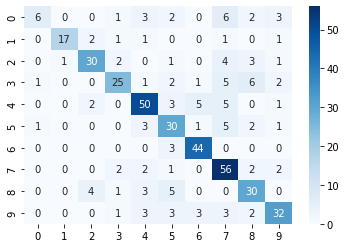

In [48]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in validation_ds], axis=1)

labels = np.argmax(results[0], axis=1)
predictions = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

#disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
#disp.plot()

print(classification_report(labels, predictions, digits = 4))

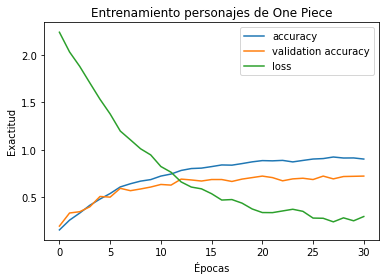

In [49]:
from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['loss'], label='loss')

plt.title('Entrenamiento personajes de One Piece')

plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend(loc="upper right")

plt.show()

(200, 200, 3)
El vector de salida obtenido:  [[4.1364729e-05 9.9963903e-01 9.1728216e-06 9.2651666e-05 3.9801165e-07
  4.6760466e-08 1.0030088e-06 2.1575794e-04 2.4010239e-07 3.0388219e-07]]
La etiqueta de salida predicha es  1
Ahora dicho con texto: La etiqueta de salida predicha es  Chopper


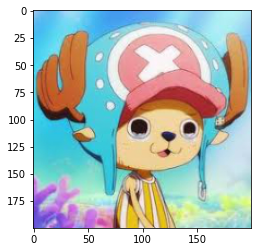

In [50]:
# PRODUCTION ----------------------------------------------

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import tensorflow.keras

# LOADING --------------------------------------------------
#model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['Ace', 'Chopper', 'Franky', 'Luffy', 'Nami', 'Robin', 'Sanji', 'Shanks', 'Usopp', 'Zoro']
%matplotlib inline

pil_im = Image.open('../input/onepiecedata200/out2/test/Chopper/38.jpg', 'r')
im = np.asarray(pil_im.resize((200, 200)))
imshow(im)
print(im.shape) # La imagen es un array de dimensión: 150x150x3

# El método `predict` hace la predicción de un lote de entradas, no solo una. 
# En el caso de que tengamos solo una entrada deberemos añadirle una dimensión más 
# al array numpy para que la entrada tenga la dimensión: 1x150x150x3

im = im.reshape(1,200,200,3)


print('El vector de salida obtenido: ', model.predict(im))
print('La etiqueta de salida predicha es ', np.argmax(model.predict(im)))
print('Ahora dicho con texto: La etiqueta de salida predicha es ', etiquetas[np.argmax(model.predict(im))])






In [51]:
# PRODUCTION ----------------------------------------------

#from matplotlib.pyplot import imshow
import numpy as np
#from PIL import Image
import tensorflow.keras

# SAVING --------------------------------------------------
#model.save_model("mimodelo.h5")


# LOADING --------------------------------------------------
#model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['Ace', 'Chopper', 'Franky', 'Luffy', 'Nami', 'Robin', 'Sanji', 'Shanks', 'Usopp', 'Zoro']
%matplotlib inline
print("ETIQUETA PREDICHA -> ETIQUETA REAL")
for minilote in test_ds:
    prediccion_minilote = model.predict(minilote[0].numpy())
    etiqueta_real_minilote = minilote[1].numpy()
    for y_predicha, y_real in zip(np.round(prediccion_minilote,3), etiqueta_real_minilote):
        if np.argmax(y_predicha) == np.argmax(y_real):
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)])
        else:
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)], "✘")

ETIQUETA PREDICHA -> ETIQUETA REAL
Chopper -> Chopper
Sanji -> Zoro ✘
Robin -> Robin
Shanks -> Luffy ✘
Shanks -> Luffy ✘
Shanks -> Nami ✘
Franky -> Franky
Robin -> Robin
Franky -> Franky
Shanks -> Shanks
Shanks -> Usopp ✘
Usopp -> Robin ✘
Luffy -> Luffy
Nami -> Zoro ✘
Sanji -> Sanji
Robin -> Robin
Usopp -> Franky ✘
Nami -> Nami
Franky -> Chopper ✘
Ace -> Nami ✘
Franky -> Franky
Nami -> Nami
Sanji -> Sanji
Shanks -> Shanks
Nami -> Nami
Robin -> Robin
Shanks -> Shanks
Luffy -> Luffy
Robin -> Robin
Ace -> Usopp ✘
Sanji -> Sanji
Chopper -> Chopper
Franky -> Franky
Nami -> Nami
Shanks -> Shanks
Usopp -> Usopp
Nami -> Nami
Nami -> Franky ✘
Chopper -> Chopper
Chopper -> Franky ✘
Luffy -> Luffy
Nami -> Nami
Franky -> Luffy ✘
Nami -> Nami
Nami -> Nami
Zoro -> Zoro
Shanks -> Usopp ✘
Usopp -> Franky ✘
Robin -> Sanji ✘
Nami -> Luffy ✘
Luffy -> Luffy
Zoro -> Zoro
Shanks -> Chopper ✘
Nami -> Franky ✘
Zoro -> Zoro
Usopp -> Shanks ✘
Ace -> Luffy ✘
Shanks -> Shanks
Usopp -> Usopp
Shanks -> Franky ✘
Luf